<a href="https://colab.research.google.com/github/linyuehzzz/5523_project/blob/main/sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Stochastic Gradient Descent for Logistic Regression**
This code implements and tests the SGD algorithm for logistic regression
in different scenarios.  
Yifei Zhang (zhang.5387 at osu edu), Yue Lin (lin.3326 at osu.edu)  
Created: 11/12/2020

#### **Set up libraries**

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

#### **Project**

##### Projection function for hypercube

In [2]:
def cube_prj(sample):
  '''
  input: a sample with d dimension (1-D array or list)
  onput: the euclidean projection of sample
  '''
  return [np.sign(i) * min(np.abs(i), 1) for i in sample]

##### Projection function for unit ball

In [3]:
def ball_prj(sample):
    '''
    input: a sample with d dimension (1-D array or list)
    onput: the euclidean projection of sample
    '''
    ratio = 1 / np.linalg.norm(sample)
    return [i * ratio for i in sample]

##### Project data

In [4]:
def prj_data(x, y, prj_code):
    '''
    This function is for conduct projection on data array
    x: n*d array (n is sample#, d is dimension)
    y: 1-d array with label of -1 or +1
    prj_code: type of projection, 0 for cube, 1 for ball
    return:
        prj_x: projected x 
        y: same as input
    '''
    if prj_code == 0:
        prj_x = np.apply_along_axis(cube_prj, 1, x)
    elif prj_code == 1:
        prj_x = np.apply_along_axis(ball_prj, 1, x)
    else:
        print("Please input correct code for projection type: 0 for cube, 1 for ball")
      
    b = np.ones((prj_x.shape[0], 1))
    prj_x = np.append(prj_x, b, axis=1)
    return prj_x, y

##### Project gradient

In [5]:
def prj_grad(g, prj_code):
    '''
    This function is for conduct projection on gradients
    g: 1-d array (d is dimension)
    prj_code: type of projection, 0 for cube, 1 for ball
    return:
        prj_g: projected gradient
    '''
    if prj_code == 0:
        prj_g = cube_prj(g)
    elif prj_code == 1:
        prj_g = ball_prj(g)
    else:
        print("Please input correct code for projection type: 0 for cube, 1 for ball")
    return prj_g

#### **Prepare data**

In [6]:
def gen_data(sig, n):
    '''
    The function is to generate data for training and testing
    The feature array is 4 dimension array. 
     + Each feature follows the Normal distribution(mu,sig)
     + with probability 1/2, the y =1 , 
         generate the correspoinding feature vector from N(mu,sig),mu is [1/4,1/4,1/4,1/4],sig is set as you need.
    sig: the sigma of  gussian vector
    n: the sample number
    
    Return:
     x: n*d_dimension array
     y: 1-d dimension array with -1 and +1
    '''
    d_dimension = 4
    y = np.random.choice([-1, 1], p = [0.5, 0.5], size = n)
    x = np.array([])
    for i in range(n):
        if y[i] == -1:
            mu = -(1 / 4)
            negvec = np.random.normal(mu, sig, d_dimension)
            x = np.concatenate([x, negvec], axis=0)
        else:
            mu = (1/4)
            posvec = np.random.normal(mu, sig, d_dimension)
            x = np.concatenate([x,posvec], axis=0)
    x = np.reshape(x, (n, d_dimension))
    return x, y

#### **Train**
https://machinelearningmastery.com/implement-logistic-regression-stochastic-gradient-descent-scratch-python/

##### Predict using logistic regression

In [7]:
# Make a prediction with coefficients
def pred(X, w):
  yhat = 0.
  for i in range(X.shape[0]):
    yhat += w[i] * X[i]
  yhat = 1.0 / (1.0 + np.exp(-yhat))
  if yhat < 0.5:
    yhat = -1
  else:
    yhat = 1 
  return yhat

##### Estimate logistic loss

In [8]:
def log_loss(X, y, w):
  return np.log(1 + np.exp(-y * np.dot(w.T, X)))

##### Estimate classification error

In [9]:
def err(yhat, y):
  if yhat == y:
    return 0
  else:
    return 1

##### Estimate weight vector using SGD

In [10]:
def train_sgd(train_x, train_y, test_x, test_y, l_rate, n_epoch, bs, prj_code):
  w = np.random.uniform(-1, 1, (train_x.shape[1]))
  risk_all = np.zeros(n_epoch)
  cls_err_all = np.zeros(n_epoch)

  for epoch in range(n_epoch):
    risk = cls_err = grad = 0.
    for idx in range(epoch * bs, (epoch + 1) * bs):
      # Read data
      X = train_x[idx]
      y = train_y[idx]
      # Calculate gradient
      g = (-y * X * np.exp(-y * np.dot(w.T, X)) / (1 + np.exp(-y * np.dot(w.T, X))))
      grad += g

    # Project gradient
    grad = prj_grad(grad / bs, prj_code)
    # Backward propagation
    w = np.add(w, np.multiply(-l_rate, grad))
    
    # Evaluate
    for idx in range(test_x.shape[0]):
      # Read data
      X = test_x[idx]
      y = test_y[idx]
      # Predict
      yhat = pred(X, w)
      # Evaluate
      risk += log_loss(X, y, w) / test_x.shape[0]
      cls_err += err(yhat, y) / test_x.shape[0]
    
    risk_all = np.append(risk_all, risk)
    cls_err_all = np.append(cls_err_all, cls_err)
    # print('>epoch=%d, lrate=%.3f, risk=%.3f, classification error=%.3f' % (epoch, l_rate, risk, cls_err))
  
  # Report risk
  risk_ave = np.average(risk_all)
  risk_min = np.amin(risk_all)
  risk_var = np.var(risk_all)
  exp_excess_risk = risk_ave - risk_min
  # Report classification error
  cls_err_ave = np.average(cls_err_all)
  cls_err_var = np.var(cls_err_all)
  return [w, risk_ave, risk_min, risk_var, exp_excess_risk, cls_err_ave, cls_err_var]

#### **Wrapper**

##### Generate data and train

In [11]:
# Fixed hyperparameters
n_epoch = 30    # training epochs
test_n = 400    # size of test set

# Unfixed hyperparameters
prj_code = 1    # code for two scenario: 0 for cube, 1 for ball
l_rate = 0.04  # learning rate: 0.04 for cube, 0.18 for ball
train_bs = np.array([50, 100, 500, 1000])   # batch size for each training epoch
sigma = 0.1     # variance of Gaussian distribution

np.random.seed(0)

excess_risk = []
cls_error = []
excess_risk_var = []
cls_error_var = []

for bs in train_bs:
  # Generate training data
  train_x, train_y = gen_data(sigma, bs * n_epoch)
  train_px, train_py = prj_data(train_x, train_y, prj_code)

  # Generate test data
  test_x, test_y = gen_data(sigma, test_n)
  test_px, test_py = prj_data(test_x, test_y, prj_code)

  # Train
  output = train_sgd(train_px, train_py, test_px, test_py, l_rate, n_epoch, bs, prj_code)
  print(output)
  print('>scenario=%d, sigma=%.2f, n=%d, log_loss_mean=%.3f, log_loss_std_dev=%.3f, log_loss_min=%.3f, \
        excess_risk=%.3f, cls_error_mean=%.3f, cls_error_std_dev=%.3f' 
        % (prj_code+1, sigma, bs, output[1], output[3], output[2], output[4], output[5], output[6]))
  
  excess_risk = np.append(excess_risk, output[4], axis=None)
  cls_error = np.append(cls_error, output[5],  axis=None)
  excess_risk_var = np.append(excess_risk_var, output[3], axis=None)
  cls_error_var = np.append(cls_error_var, output[6],  axis=None)

[array([ 1.24843322,  1.43596784,  1.35377148, -0.3138855 ,  0.2992243 ]), 0.14773302024606283, 0.0, 0.025500772174598854, 0.14773302024606283, 0.01708333333333334, 0.0018658680555555572]
>scenario=2, sigma=0.10, n=50, log_loss_mean=0.148, log_loss_std_dev=0.026, log_loss_min=0.000,         excess_risk=0.148, cls_error_mean=0.017, cls_error_std_dev=0.002
[array([-0.02797822,  1.11189753,  0.68490599,  0.35741401,  0.09121464]), 0.25724598758925993, 0.0, 0.07455191716946045, 0.25724598758925993, 0.07558333333333331, 0.026334868055555512]
>scenario=2, sigma=0.10, n=100, log_loss_mean=0.257, log_loss_std_dev=0.075, log_loss_min=0.000,         excess_risk=0.257, cls_error_mean=0.076, cls_error_std_dev=0.026
[array([-0.02607736,  0.84896602,  0.52668798,  0.44797691,  0.26493745]), 0.29586059666010234, 0.0, 0.09817218428174751, 0.29586059666010234, 0.1460833333333334, 0.046697576388888905]
>scenario=2, sigma=0.10, n=500, log_loss_mean=0.296, log_loss_std_dev=0.098, log_loss_min=0.000,      

##### Plot excess risk

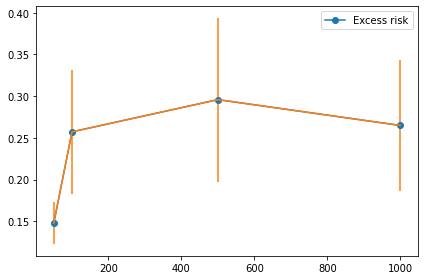

In [12]:
plt.plot(train_bs, excess_risk, '-o', label='Excess risk')
plt.errorbar(train_bs, excess_risk, excess_risk_var)
plt.legend()
plt.tight_layout()
plt.show()

##### Plot classification error

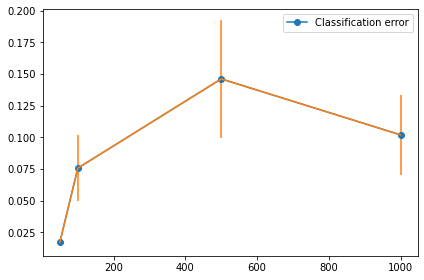

In [14]:
plt.plot(train_bs, cls_error, '-o', label='Classification error')
plt.errorbar(train_bs, cls_error, cls_error_var)
plt.legend()
plt.tight_layout()
plt.show()